<a href="https://colab.research.google.com/github/Olegkaps/ML_HW/blob/main/Kapshayi_Oleg_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Пояснение: в каждой домашке приведена только часть ноутбука с домашним заданием, но в домашнем задании используются переменные из первой части соответствующего нотбука.

# Hometask 1

## Task 1

Please, provide an example where even EM-based algorithm estimates expression wrong. Describe in which exact cases it might happens.

Алгоритм максимизации подобия может неправильно оценивать экспрессию в случае, если чтения картируются неоднозначно.
Допустим некоторые чтения попадают на экзоны нескольких генов, причем такой экзон встречается в одной изоформе гена. Для простоты скажем, что экзон попал в разные гены путем переноса транспозонами. Тогда оценка экспрессии изоформ будет зависеть от того как мы будем обрабатывать множественные картировки. <ol><li>Мы не учитываем множественные картировки => недооцениваем соответствуещие изоформы.
<li>Мы учитываем множественные картировки для обоих генов => переоцениваем обе изоформы.
</ol>

## Task 2

Using [recount3](https://rna.recount.bio/), find any available RNA-Seq dataset (only one sample will be enough) with already estimated expressions at the level of gene counts. Re-estimate the expressions with `kallisto` and compare the results (at the gene level).

In [ ]:
!wget https://bowtie-bio.sourceforge.net/recount/countTables/nagalakshmi_count_table.txt
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR002/SRR002061/SRR002061.fastq.gz	0	rhexprimed-orig-2
!wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/146/045/GCA_000146045.2_R64/GCA_000146045.2_R64_rna_from_genomic.fna.gz

In [ ]:
!mv GCA_000146045.2_R64_rna_from_genomic.fna.gz reference.fna.gz
!mv nagalakshmi_count_table.txt count_table.txt

In [ ]:
!./kallisto/build/src/kallisto index -i reference.idx reference.fna.gz

In [ ]:
!./kallisto/build/src/kallisto quant -i reference.idx -o results --single -l 50 -s 1 SRR002061.fastq.gz

In [ ]:
import pandas as pd


count_table = pd.read_csv("/content/count_table.txt", sep="\t")
count_table["SRX000561"] /= count_table["SRX000561"].sum()
del count_table["SRX000559and60"]
del count_table["SRX000564"]
del count_table["SRX000562and3"]


kallisto_results = pd.read_csv("results/abundance.tsv", sep="\t")
kallisto_results.tpm /= kallisto_results.tpm.sum()
del kallisto_results["length"]
del kallisto_results["eff_length"]
del kallisto_results["est_counts"]

In [ ]:
count_table.describe(), kallisto_results.describe()

[         SRX000561
 count  7130.000000
 mean      0.000140
 std       0.000627
 min       0.000000
 25%       0.000007
 50%       0.000041
 75%       0.000101
 max       0.029098,
                tpm
 count  6418.000000
 mean      0.000156
 std       0.000910
 min       0.000000
 25%       0.000011
 50%       0.000027
 75%       0.000068
 max       0.047964]

Text(0, 0.5, 'count')

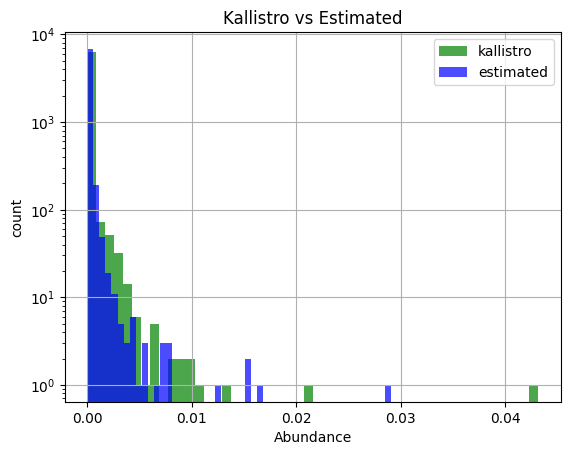

In [ ]:
import matplotlib.pyplot as plt


plt.hist(kallisto_results['tpm'] * 6418/7130, alpha=0.7, color='green', label='kallistro', bins=50)
plt.hist(count_table['SRX000561'], alpha=0.7, color='blue', label='estimated', bins=50)
plt.yscale('log')
plt.title("Kallistro vs Estimated")
plt.legend()
plt.grid()
plt.xlabel("Abundance")
plt.ylabel("count")

Как мы видим, Kallistro оценивает уровень экспрессии выше, так как большее количество большее количество генов имеют высокое значение метрики. Также Kallistro оценивает уровень экспрессии для отдельных генов до 0.05 по сравнению с 0.03 у ранней оценки. От части это связано с тем, что взятый мною референс содержит 6418 последовательности РНК, а таблица каунтов содержит 7130 представителя (к сожалению референс оказался таким). Однако, на графике приведены частоты с поправкой на размер и все равно видны различия между старой и новой оценкой экспрессии.

Таким образом Kallistro дает оценку экспрессии для некоторых генов выше.

# Hometask 2

At home, perform the same analysis with the standard DESeq2 pipeline. DESeq2 documentation is very detailed: https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html. For each step, comment, how it relates to what we did in edgeR.

You can then compare lists of differentially expressed genes between edgeR and DESeq2 using Venn diagrams or plot the p-values of different genes in edgeR and DESeq2 against each other.

And feel free to ask questions! @daniilbobrovskiy

In [ ]:
%%R
suppressPackageStartupMessages(library(DESeq2))

# Hometask 3

## Task 1

Number of UMIs per cell in the dataset is distributed (approximately) bimodally. What is the reason for that? Please provide some papers and/or resourses when this phenomenon is described.

Распределение UMI на клетку получается по причине того, что распределение получается из суммы распределений "нормальных" клеток и пустых капель, в которые не попали клетки. Пустые капли отвечают меньшей моде. Этот феномен упоминается в некоторых статьях [1](https://www.biorxiv.org/content/10.1101/2024.02.10.579769v1.full) [2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02084-2) [3](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1438-9)

## Task 2

Using [Cellxgene Portal](https://cellxgene.cziscience.com/) please select the dataset of your scientific interest and perform QC. Are you happy with it? Please save files in `loom` format and describe the features of such a format.

In [ ]:
!wget https://datasets.cellxgene.cziscience.com/9110306e-b579-408f-8c96-d0a9c60b391f.h5ad
!pip install scanpy[leiden] scrublet

In [ ]:
import scanpy as sc
import seaborn as sns
import numpy as np

sc.settings.verbosity = 3

In [ ]:
adata = sc.read_h5ad("9110306e-b579-408f-8c96-d0a9c60b391f.h5ad")

In [ ]:
adata.var_names_make_unique()

Pipeline from scanpy site with automatic thresholding using MAD

In [ ]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

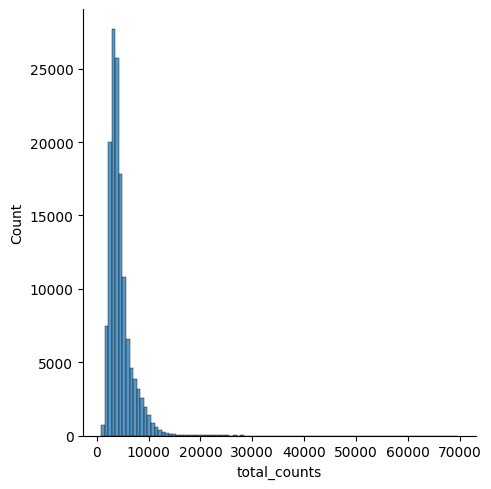

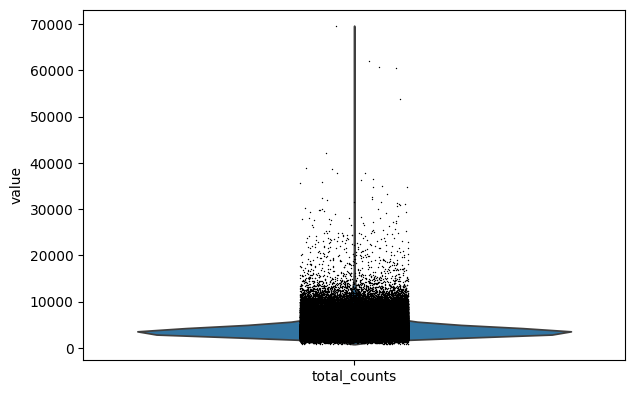

In [ ]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, 'total_counts')
# there is no mitochondial genes
#p2 = sc.pl.violin(adata, "pct_counts_mt")
#p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

На графике видно огромное количество капель с нулевым или почти нулевым каунтом. Это нужно поправить при помощи QC

In [ ]:
from scipy.stats import median_abs_deviation



def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [ ]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)

In [ ]:
data = adata.X[adata.obs["outlier"] == False]

<Axes: ylabel='Count'>

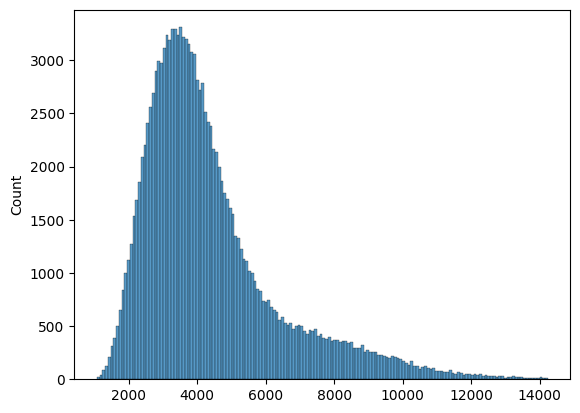

In [ ]:
# UMI per cell distribution

counts_per_cell = data.sum(axis=1).A.T[0]
sns.histplot(counts_per_cell)

<Axes: ylabel='Count'>

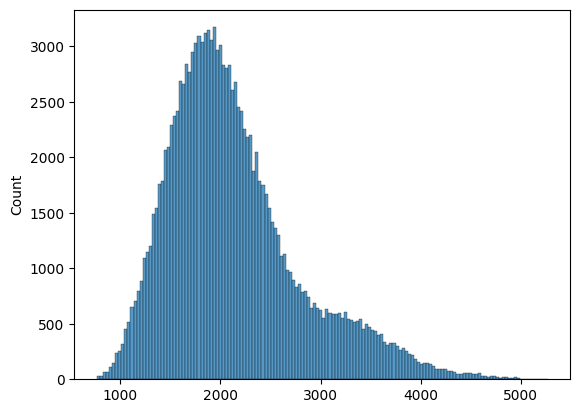

In [ ]:
# Number of genes per cell distribution

genes_per_cell = (data > 0).sum(axis=1).T.A[0]
sns.histplot(genes_per_cell)

После применения QC распределение UMI на клетку стало выглядеть прилично. Однако оно не похоже на бимодальное, что даже хорошо, т.к означает почти полное отсутствие пустых капель и дублетов (нельзя утверждать, что их нет совсем). Полученным качеством я доволен.

In [ ]:
!pip install loompy

In [ ]:
adata.write_loom(filename="PBMC_Scanpy.loom")

Формат Loom удобен тем, что он позволяет быстро и легко добавлять метаданные к строкам и столбцам матрицы в отличие от SQL БД (С сайта loompy).

# Hometask 4

## Task 1

Please, code (without using ready-to-go single-cell tools) one of the following dimensionality reduction and describe similarities / dissimilarities with PCA in resulting embedding. Feel free in methods and interpretation — creativity is a key:

1. LDA,
2. VAE,
3. ICA.

LDA - Линейный дискриминантный анализ, алгоритм классификации и понижения размерности. Он основан на том, что признаки имеют многомерное нормальное распределение. В ходе понижения размерности подбирается такое линейное отображение, что классы отделяются друг от друга (уменьшается внутриклассовая дисперсия и увеличивается межклассовая дисперсия). Этот метод как и PCA понижает размерность на основе дисперсии, однако отличается тем, что пытается разделить классы а не просто увеличить дисперсию. В случае, если классы линейно разделимы, LDA будет работать лучше.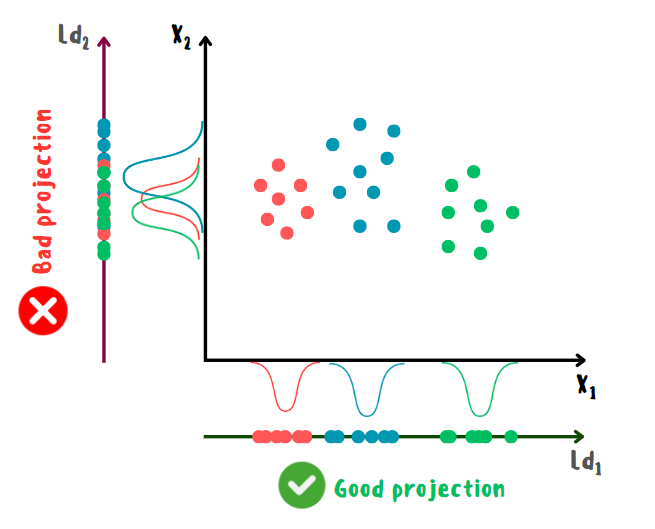

Код для выполнения LDA при помощи sklearn. В качестве классов я выбрал кластеры, предсказанные k-means.

In [ ]:
from sklearn.cluster import KMeans


y = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(adata.X.A)

In [ ]:
y.labels_

array([1, 1, 1, ..., 0, 3, 2], dtype=int32)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


lda = LDA(n_components=2)
lda.fit(adata.X.A, y.labels_)

LinearDiscriminantAnalysis(n_components=2)

In [ ]:
x_lda = lda.transform(adata.X.A)

In [ ]:
x_lda

array([[ 9.84195838, -0.47072272],
       [12.51909731, -1.39421031],
       [11.54445728, -0.92977045],
       ...,
       [-9.1696643 , -0.76318541],
       [-9.79312168, -2.58124185],
       [-2.72968913, 11.23257675]])

Text(0, 0.5, 'lda_2')

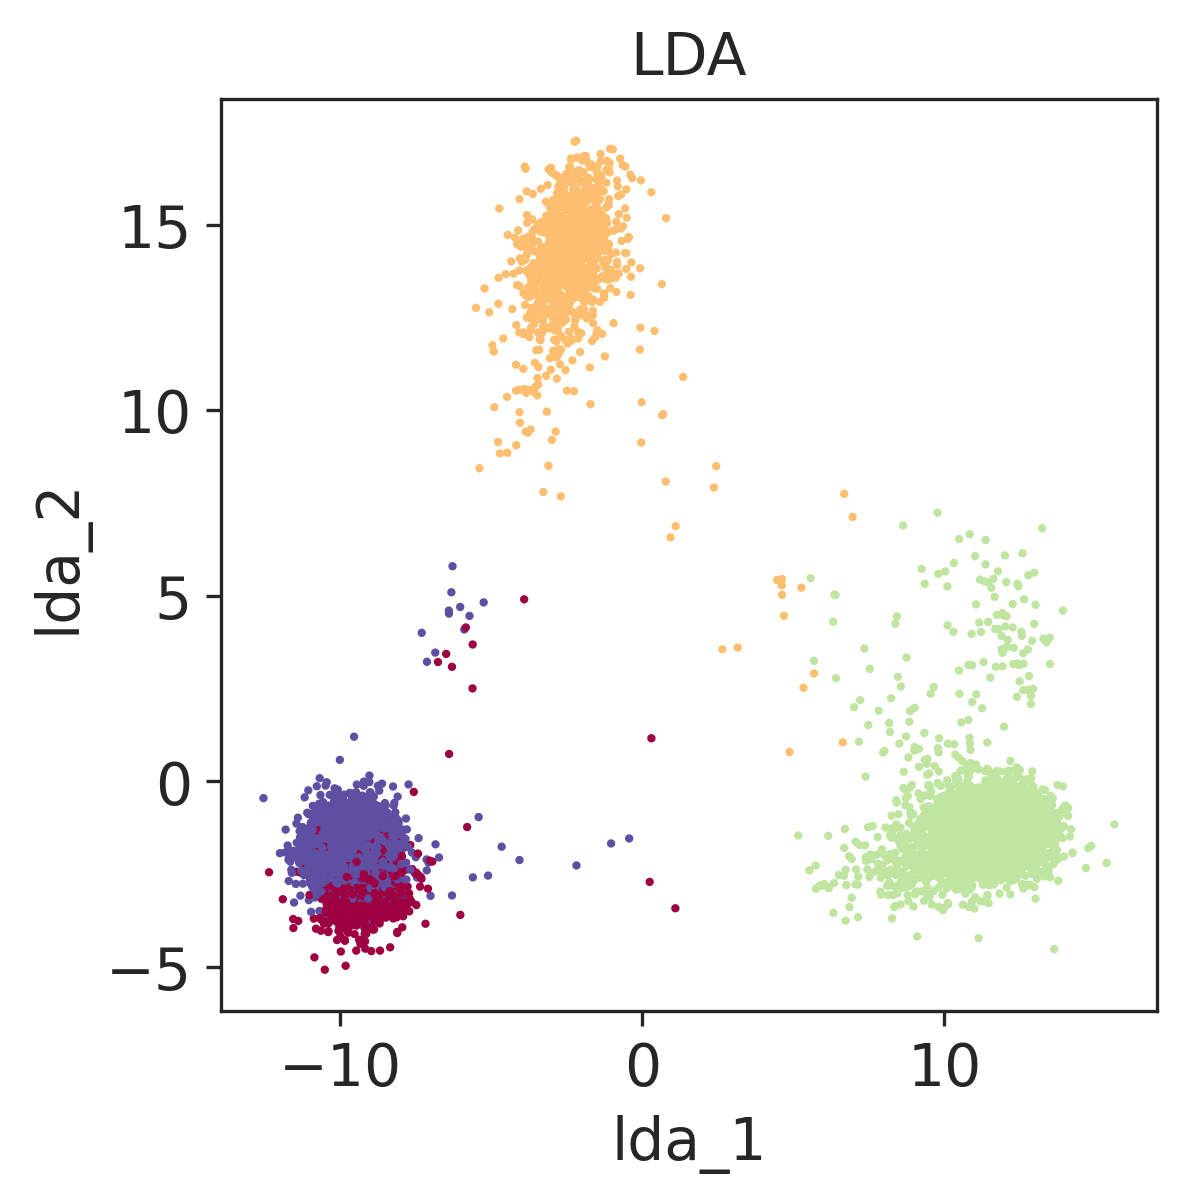

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(x_lda[:, 0], x_lda[:, 1], s=1, c=y.labels_, cmap='Spectral_r')
plt.title("LDA")
plt.xlabel("lda_1")
plt.ylabel("lda_2")

Как видно, LDA относительно хорошо справился со снижением размерности, а также кластера выглядят более округло по сравнению с UMAP и PCA, т.к LDA считает каждый кластер распределенным нормально.

In [ ]:
adata.var.shape

(3000, 13)

In [ ]:
adata.X.A.shape

(11496, 3000)

# Hometask 5

## Task 1

Try to integrate the dataset from the workshop with following techniques:
1. scanorama,
2. BBKNN,
3. scVI,
4. combat.

Which method works better, which — worse? Please motivate your answer.

1) scanorama

In [ ]:
# split per batch into new objects.
batches = ['P1','P2','P3']
adatas = [adata[adata.obs["donor"] == batch] for batch in batches]

In [ ]:
!pip install scanorama

In [ ]:
import scanorama

# run scanorama.integrate
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 3000 genes among all datasets
[[0.         0.81661637 0.33179353]
 [0.         0.         0.85077325]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


In [ ]:
adata_spatial = sc.concat(adatas_cor)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


<Axes: title={'center': 'Scanorama umap'}, xlabel='UMAP1', ylabel='UMAP2'>

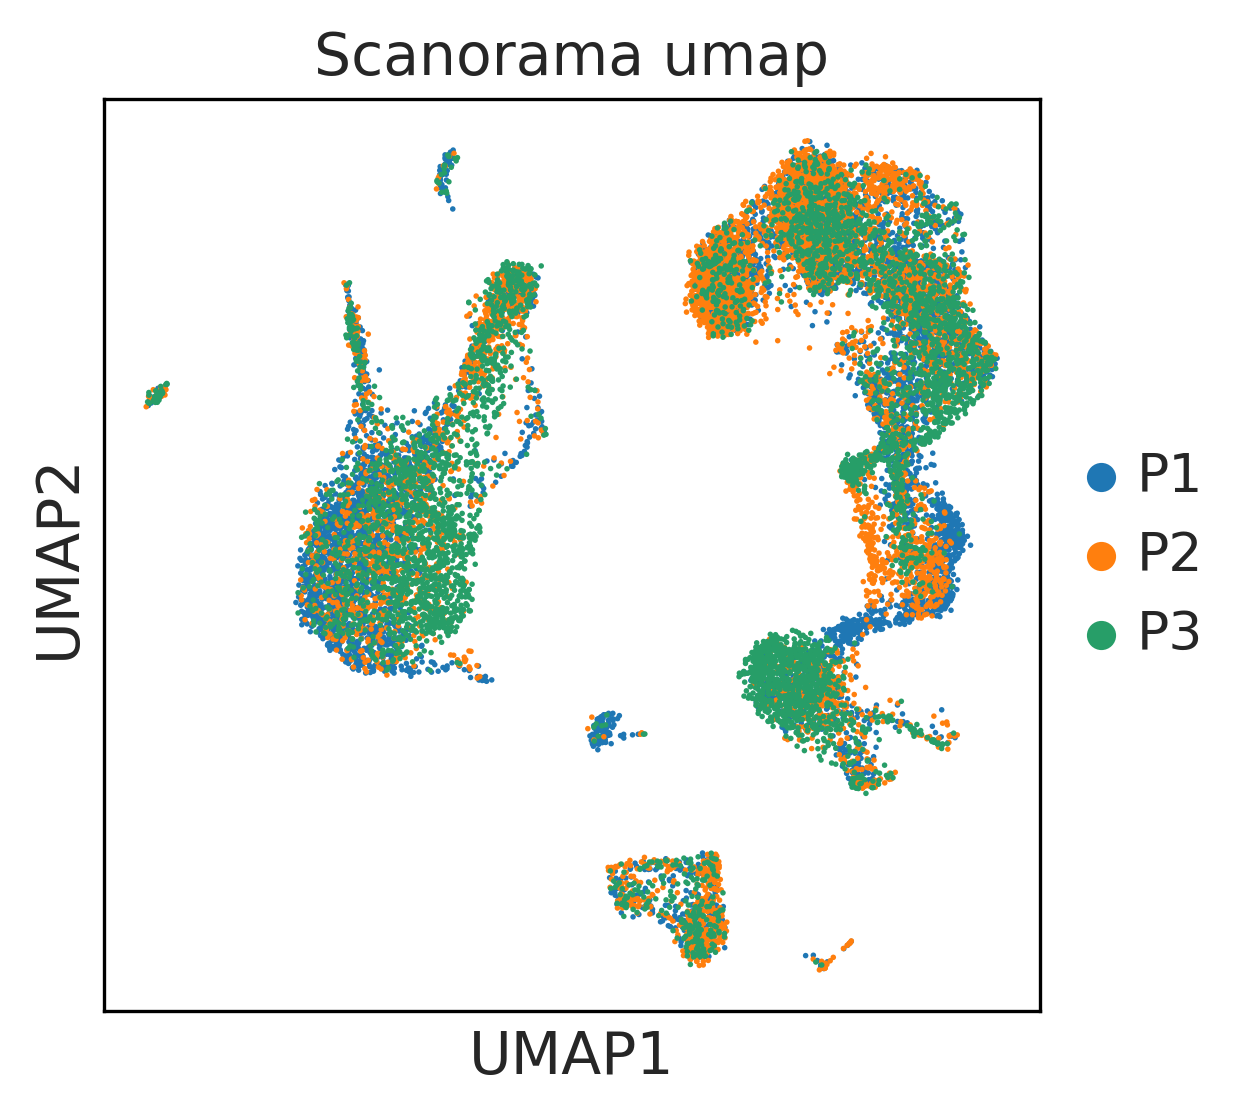

In [ ]:
sc.pp.neighbors(adata_spatial, n_pcs =50, use_rep = "X_scanorama")
sc.tl.umap(adata_spatial)
sc.pl.umap(adata_spatial, color="donor", title="Scanorama umap", show=False)

2) BBKNN

In [ ]:
!pip install bbknn

In [ ]:
adata_bbknn = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

sc.pp.pca(adata_bbknn, n_comps=20)

computing PCA
    with n_comps=20
    finished (0:00:06)


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


<Axes: title={'center': 'BBKNN umap'}, xlabel='UMAP1', ylabel='UMAP2'>

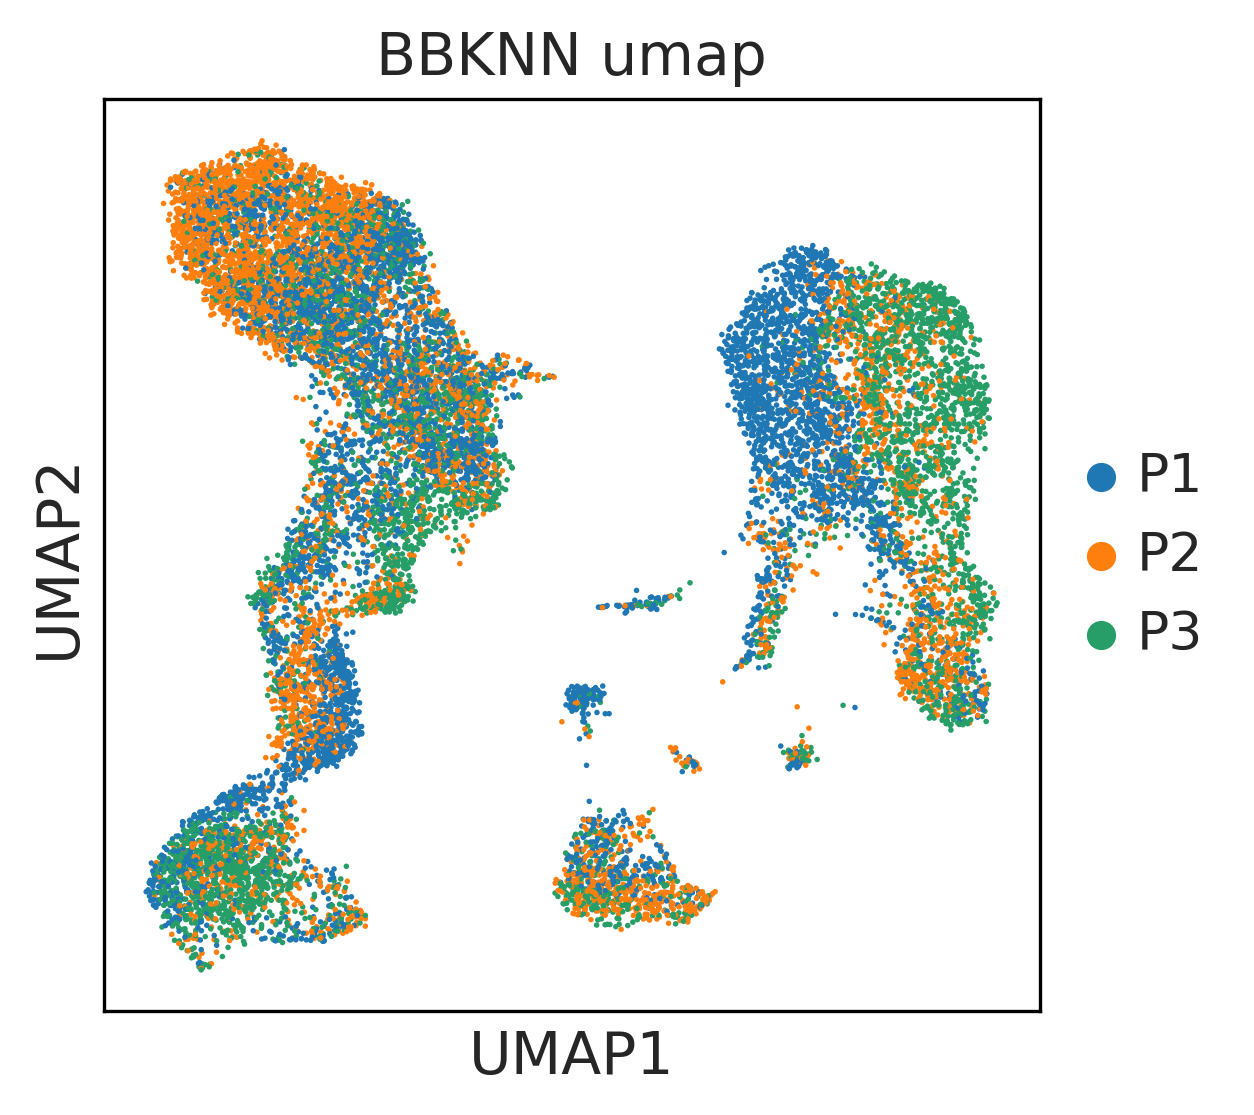

In [ ]:
sc.external.pp.bbknn(adata_bbknn, batch_key='donor')

sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color="donor", title="BBKNN umap", show=False)

3) scVI

In [ ]:
!pip install scvi scvi-tools

In [ ]:
import scvi
import torch

In [ ]:
adata_scvi = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

#normalize and log-transform
sc.pp.normalize_per_cell(adata_scvi, counts_per_cell_after=1e4)
sc.pp.log1p(adata_scvi)

# first store the raw data
adata_scvi.raw = adata_scvi

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [ ]:
scvi.model.SCVI.setup_anndata(
    adata_scvi,
    categorical_covariate_keys=["donor"],
    continuous_covariate_keys=["pct_counts_mt"],
)

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [ ]:
model = scvi.model.SCVI(adata_scvi, n_latent=100, n_layers=3)

model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:02<17:35,  2.65s/it, v_num=1, train_loss_step=6.21e+3, train_loss_epoch=6.66e+3]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [17:57<00:00,  2.65s/it, v_num=1, train_loss_step=5.65e+3, train_loss_epoch=5.54e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [17:57<00:00,  2.69s/it, v_num=1, train_loss_step=5.65e+3, train_loss_epoch=5.54e+3]


In [ ]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata_scvi.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(16991, 100)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


<Axes: title={'center': 'scVI umap'}, xlabel='UMAP1', ylabel='UMAP2'>

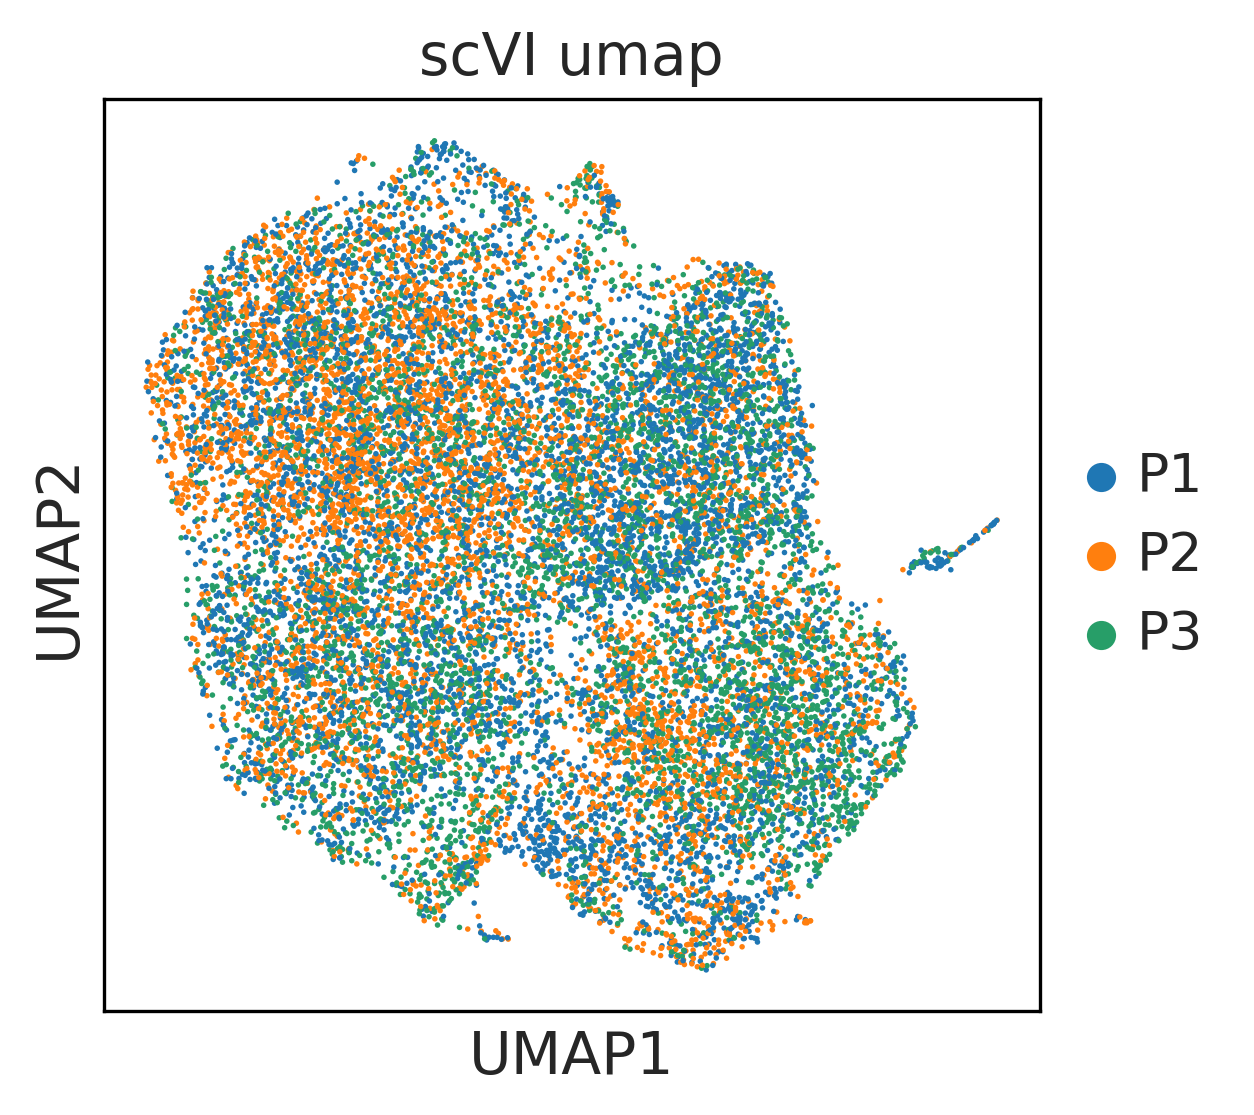

In [ ]:
sc.pp.neighbors(adata_scvi, n_pcs =50, use_rep = "X_scVI")
sc.tl.umap(adata_scvi)
sc.pl.umap(adata_scvi, color="donor", title="scVI umap", show=False)

4) combat. Эта программа потребляет невменяемо много памяти, поэтому я взял 50% датасета.

In [ ]:
adata_combat = sc.AnnData(X=adata.raw.X[::2], var=adata.raw.var, obs = adata.obs[::2])

#normalize and log-transform
sc.pp.normalize_per_cell(adata_combat, counts_per_cell_after=1e4)
sc.pp.log1p(adata_combat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [ ]:
# run combat
sc.pp.combat(adata_combat, key='donor')

Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Found 3200 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=30
    finished (0:00:49)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


<Axes: title={'center': 'combat umap'}, xlabel='UMAP1', ylabel='UMAP2'>

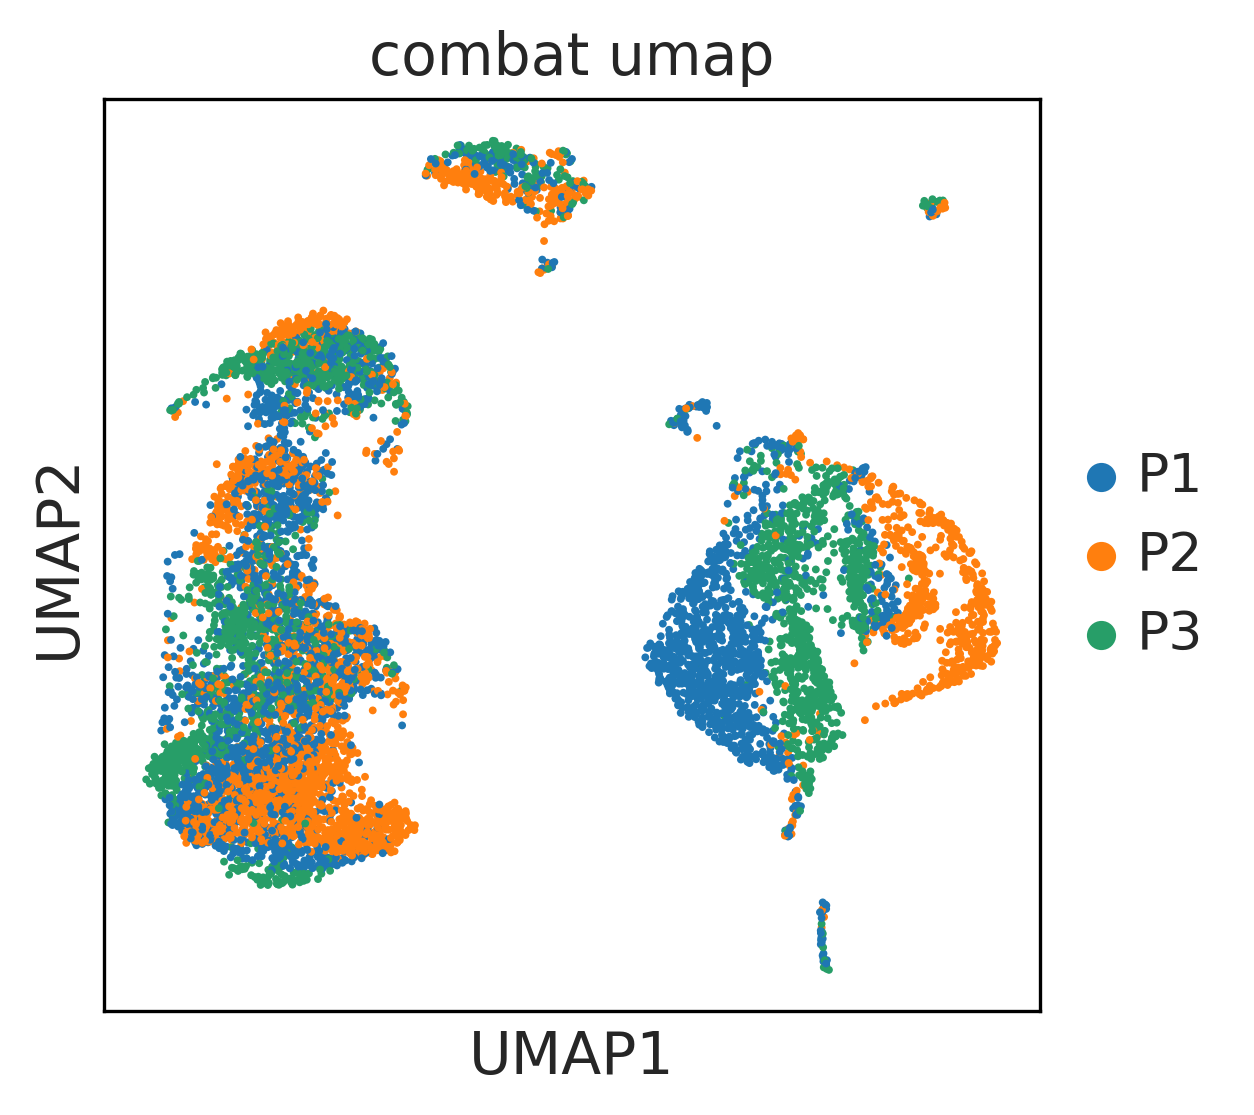

In [ ]:
sc.pp.neighbors(adata_combat, n_pcs =30)

sc.tl.umap(adata_combat)
sc.pl.umap(adata_combat, color="donor", title="combat umap", show=False)

Как видно, лучше с батч-эффектом справились BBKNN и scanorama. Combat не полностью исправил один из кластеров, особенно с учетом количества оперативной памяти, который он использует. А scVI очень хорошо слил батчи, но также слил кластеры. Стоит отметить, что scVI могла справиться с задачей лучше, проблема в подборе параметров.

## Task 2

Using [Cellxgene Portal](https://cellxgene.cziscience.com/) choose the dataset of your scientific interest (keep only 5-6 batches) and try to reproduce the clustering with corresponding cell types. Does it agree with provided cell type annotation?

In [ ]:
!pip install scanpy[leiden]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce

sns.set_style("ticks") # style
sc.settings.verbosity = 3 # amount of output
sc.set_figure_params(dpi=150)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!wget https://datasets.cellxgene.cziscience.com/80d1f22a-8f51-49dd-b30b-9704543e6ab0.h5ad

In [ ]:
adata = sc.read_h5ad("80d1f22a-8f51-49dd-b30b-9704543e6ab0.h5ad")

adata

AnnData object with n_obs × n_vars = 146583 × 33145
    obs: 'Sample', 'Tissue_in_paper', 'Batch', 'Sample_Barcode', 'sum', 'detected', 'Study', 'Patient_type', 'Patient_status', 'MT.prop', 'sizeFactor', 'Global_cluster_selected', 'Celltypes_global', 'Tissuetypes_global', 'Detailed_Cell_Type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'donor_id', 'suspension_type', 'development_stage_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'X_name', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_umap_MinDist_0.01_N_Neighbors_15', 'X_umap_MinDist_0.05_N_Neighbors_

In [ ]:
adata = adata[adata.obs["Batch"].isin(['SLX-12927', 'SLX-14096', 'SLX-19113', 'SLX-19289',
                               'SLX-19592', 'SLX-19831'])]

1) QC

In [ ]:
adata.var["mt"] = adata.var.index.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

<ipython-input-6-42da84a85ad9>:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var.index.str.startswith("MT-")


In [ ]:
adata = adata[adata.obs.n_genes_by_counts >= 700]
adata

In [ ]:
sc.pp.scrublet(adata, batch_key="Batch")
adata = adata[adata.obs.doublet_score <= 0.2]

Normallization

In [ ]:
adata_counts = adata.copy()

In [ ]:
adata = adata_counts.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key="Batch", n_top_genes=3000)

adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

In [ ]:
!pip install bbknn

In [ ]:
sc.pp.pca(adata, n_comps=20)

computing PCA
    with n_comps=20
    finished (0:00:07)


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


<Axes: title={'center': "'Before'umap"}, xlabel='UMAP1', ylabel='UMAP2'>

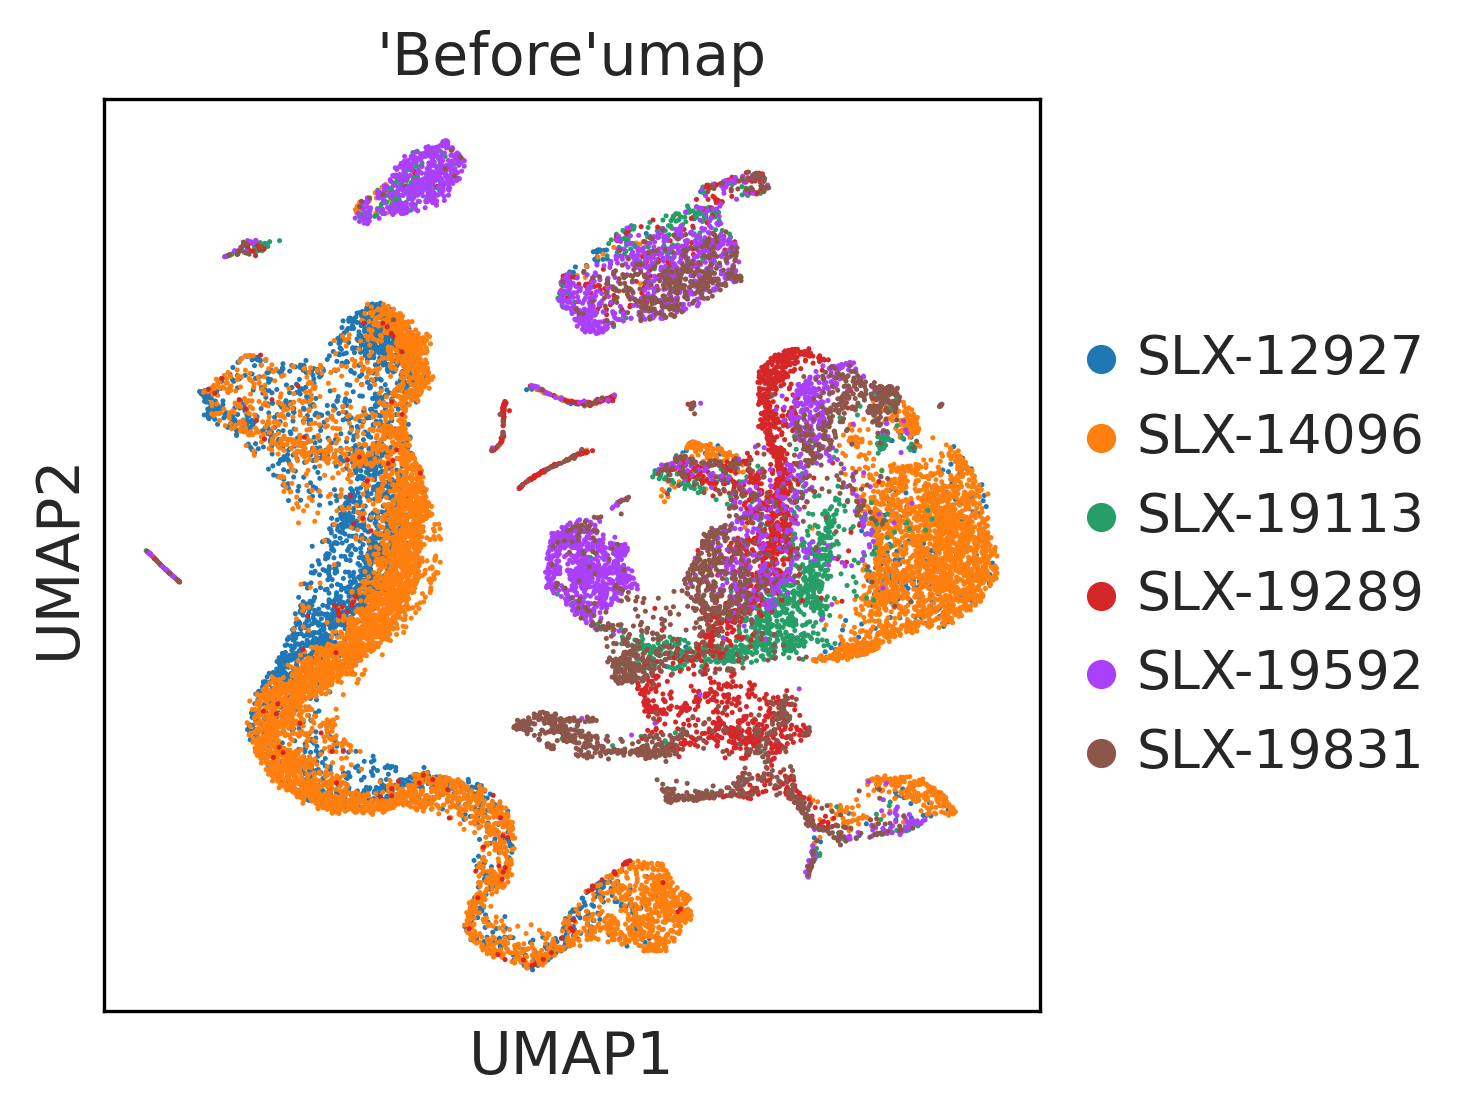

In [ ]:
sc.pp.neighbors(adata)


sc.tl.umap(adata)
sc.pl.umap(adata, color="Batch", title="'Before'umap", show=False)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


<Axes: title={'center': 'BBKNN umap'}, xlabel='UMAP1', ylabel='UMAP2'>

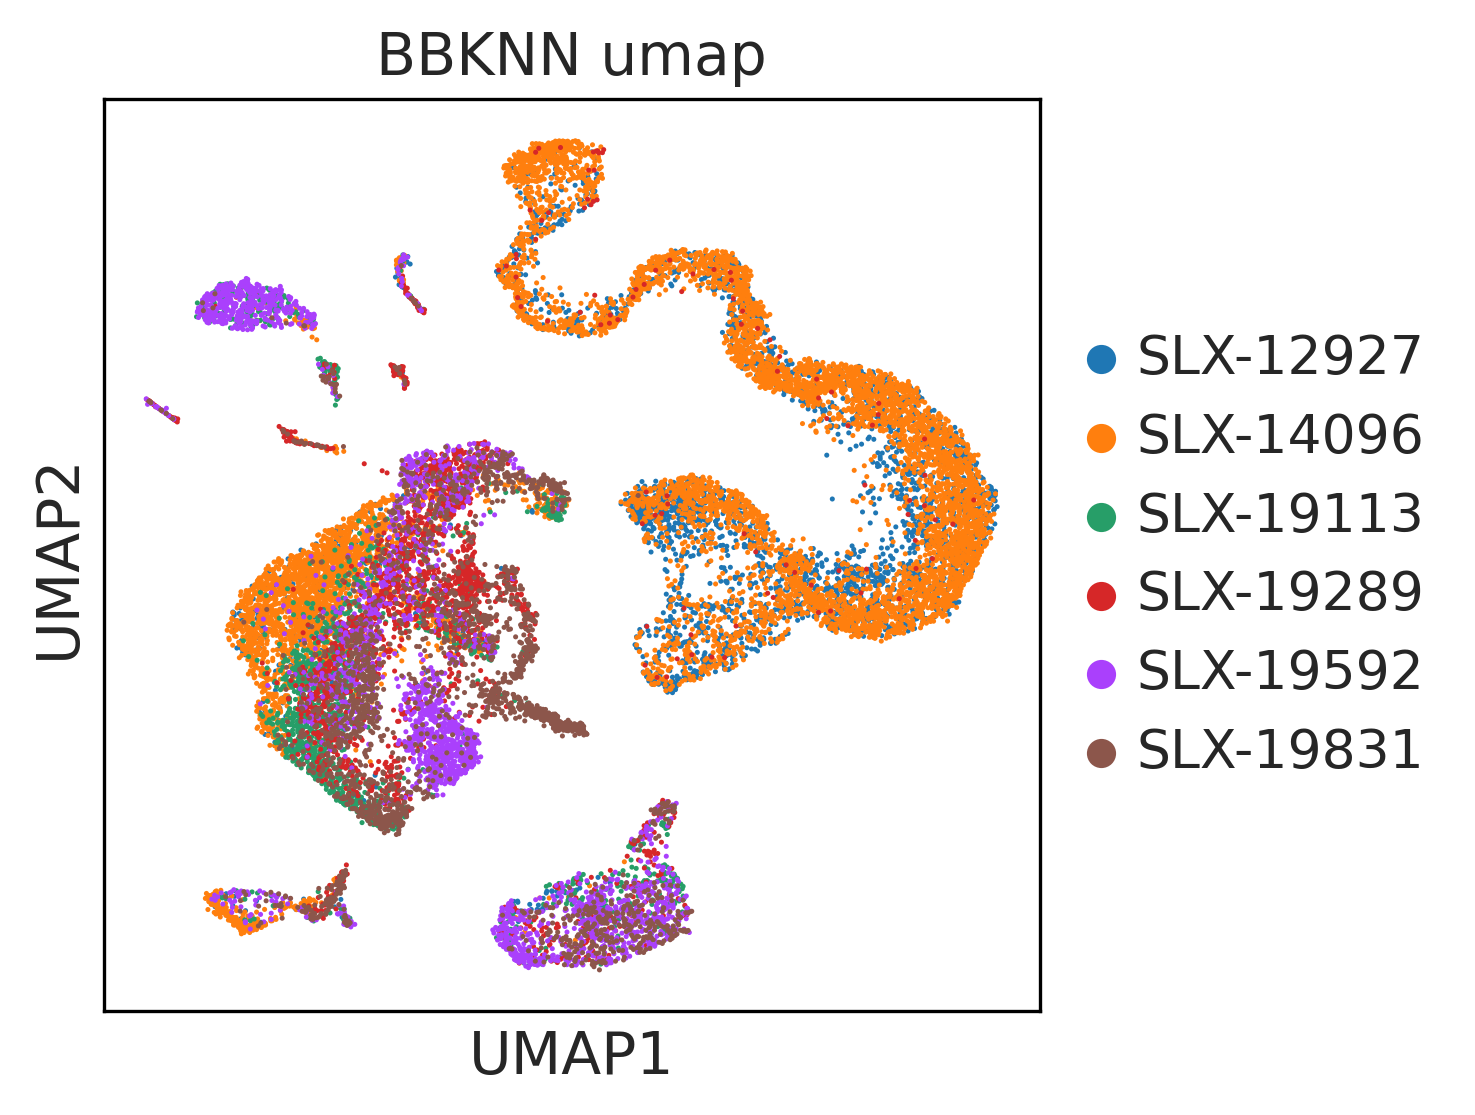

In [ ]:
sc.external.pp.bbknn(adata, batch_key='Batch')

sc.tl.umap(adata)
sc.pl.umap(adata, color="Batch", title="BBKNN umap", show=False)

После BBKNN батчи слились в большой степени, однако резкльтат не идеальный. В центральной части графика BBKNN батчи хорошо отделяются друг от друга. Если сравнивать с предыдущими попытками избавиться от батч-эффекта, то результат хороший.